In [1]:
!pip install sentence-transformers torch torchvision scikit-learn scipy pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import json
import time
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
import pandas as pd
import random
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("GPU not available - make sure to enable GPU in Runtime > Change runtime type")

def load_and_prepare_dataset(file_path):
    """Load dataset with basic preparation"""
    encodings_to_try = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    df = None

    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"✅ Successfully loaded dataset with {encoding} encoding")
            break
        except Exception as e:
            continue

    if df is None:
        raise ValueError("❌ Could not load the file with any encoding")

    print(f"\n📊 Dataset Information:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")

    # Clean dataset
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
        print("🧹 Removed 'Unnamed: 0' column")

    # Handle missing values
    initial_size = len(df)
    df = df.dropna()
    removed_rows = initial_size - len(df)
    if removed_rows > 0:
        print(f"🧹 Removed {removed_rows} rows with missing values")

    print(f"📏 Final dataset shape: {df.shape}")
    return df

dataset_file = '../datasets/combined_dataset_cleaned.csv'
df = load_and_prepare_dataset(dataset_file)

# Configuration
SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5


model_name = "Davlan/afro-xlmr-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: Tesla T4
GPU memory: 15.8 GB
✅ Successfully loaded dataset with latin-1 encoding

📊 Dataset Information:
   Shape: (6250, 3)
   Columns: ['sentence1', 'sentence2', 'label']
📏 Final dataset shape: (6250, 3)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [7]:
def preprocess(ds):
    return tokenizer(ds["sentence1"], ds["sentence2"], truncation=True, padding="max_length", max_length = 128)

"""Set seeds for all random number generators to ensure reproducibility"""
def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"All seeds set to {seed}")

def compute_metrics(preds):
    predictions, labels = preds
    predictions = predictions.squeeze()
    mse = mean_squared_error(labels, predictions)
    mae = mean_absolute_error(labels, predictions)
    pearson = pearsonr(labels, predictions)[0]
    spearman = spearmanr(labels, predictions)[0]
    return {"mse": mse, "mae": mae, "pearson": pearson, "spearman": spearman}

def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, seed=SEED):
    # First split: separate train from (val + test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(val_size + test_size),
        random_state=seed,
        shuffle=True
    )

    # Second split: separate val from test
    val_ratio = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio,
        random_state=seed,
        shuffle=True
    )

    return train_df, val_df, test_df

In [8]:
set_all_seeds(SEED)

All seeds set to 42


In [ ]:
train_path = "../saves/tokenizations/train_afro-xlmr-final-ft"
eval_path = "../saves/tokenizations/eval_afro-xlmr-final-ft"
test_path = "../saves/tokenizations/test_afro-xlmr-final-ft"

if (
    os.path.exists(train_path) and os.path.isdir(train_path)
    and os.path.exists(eval_path) and os.path.isdir(eval_path)
    and os.path.exists(test_path) and os.path.isdir(test_path)
):
    print("✅ Tokenized datasets already exist. Loading from disk...")
    tokenized_train = load_from_disk(train_path)
    tokenized_eval = load_from_disk(eval_path)
    tokenized_test = load_from_disk(test_path)
else:
    print("Tokenized datasets not found. Creating splits and preprocessing...")

    # Split dataset
    train_df, eval_df, test_df = split_dataset(df)
    train_ds = Dataset.from_pandas(train_df)
    eval_ds = Dataset.from_pandas(eval_df)
    test_ds = Dataset.from_pandas(test_df)
    print("✅ Dataset splitting complete")

    # Tokenize
    tokenized_train = train_ds.map(preprocess, batched=True)
    tokenized_eval = eval_ds.map(preprocess, batched=True)
    tokenized_test = test_ds.map(preprocess, batched=True)
    print("✅ Tokenization complete")

    # Save
    print("Saving tokenized splits to disk")
    tokenized_train.save_to_disk(train_path)
    tokenized_eval.save_to_disk(eval_path)
    tokenized_test.save_to_disk(test_path)
    print("✅ Save complete")

Tokenized datasets not found. Creating splits and preprocessing...
✅ Dataset splitting complete


Map:   0%|          | 0/4375 [00:00<?, ? examples/s]

Map:   0%|          | 0/937 [00:00<?, ? examples/s]

Map:   0%|          | 0/938 [00:00<?, ? examples/s]

✅ Tokenization complete
Saving tokenized splits to disk


Saving the dataset (0/1 shards):   0%|          | 0/4375 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/937 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/938 [00:00<?, ? examples/s]

✅ Save complete


In [ ]:
def full_train(model, tokenized_train, tokenized_eval, tokenized_test):
    args = TrainingArguments(
        output_dir="afro-xlmr-final-ft",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        num_train_epochs=4,
        save_strategy="epoch",
        report_to="none",
        logging_dir="../saves/logs",
        logging_steps=10,  # Show logging every 10 steps
        logging_strategy="steps",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        compute_metrics=compute_metrics
    )

    print("✅ Training started")
    trainer.train()
    print("✅ Training finished")

    print("✅ Saving model to disk")
    trainer.save_model(os.path.join("../saves/models/", "checkpoint"))
    print("✅ Save complete!")

    print("✅ Evaluating by metrics...")
    results = trainer.evaluate()
    print("✅ Evaluation by metrics done!")

    print("✅ Saving metrics to disk")
    results_path = os.path.join("../saves/eval_results/", "eval_results.json")
    with open(results_path, "w") as f:
        json.dump(results, f, indent=4)
    print("✅ Save complete!")

    return model, results

In [11]:
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Get model
# Check if folder exists
model_path = os.path.join("../saves/models/", "afroxlmr_checkpoint")

# Check for key model files, run full training if not found
if os.path.exists(model_path) and os.path.isdir(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    config_file = os.path.join(model_path, "config.json")
    print("✅ Model found, safe to load.")
else:
    print("❌ Model folder does not exist.")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, problem_type="regression").to(device)
    model, results = full_train(model, tokenized_train, tokenized_eval, tokenized_test)
    print("Results:")
    print(results)

❌ Model folder does not exist.


config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Training started


Step,Training Loss
10,0.265300
20,0.089300
30,0.081300
40,0.067200
50,0.052400
60,0.054700
70,0.050700
80,0.052500
90,0.054800
100,0.052800


✅ Training finished
✅ Saving model to disk
✅ Save complete!
✅ Evaluating by metrics...


✅ Evaluation by metrics done!
✅ Saving metrics to disk
✅ Save complete!
Results:
{'eval_loss': 0.017474127933382988, 'eval_mse': 0.01747412607073784, 'eval_mae': 0.10250774770975113, 'eval_pearson': 0.820273220539093, 'eval_spearman': 0.8203792117441868, 'eval_runtime': 16.6832, 'eval_samples_per_second': 56.164, 'eval_steps_per_second': 1.798, 'epoch': 4.0}


In [ ]:
def get_predictions_and_errors(model, dataset, tokenizer, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_inputs = []

    for entry in dataset:
        inputs = tokenizer(
            entry["sentence1"],
            entry["sentence2"],
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            output = model(**inputs).logits.squeeze().cpu().item()

        all_preds.append(output)
        all_labels.append(entry["label"])
        all_inputs.append((entry["sentence1"], entry["sentence2"]))

    df = pd.DataFrame(all_inputs, columns=["sentence1", "sentence2"])
    df["true_label"] = all_labels
    df["predicted"] = all_preds
    df["abs_error"] = np.abs(df["predicted"] - df["true_label"])
    df["squared_error"] = (df["predicted"] - df["true_label"]) ** 2

    return df

In [ ]:
# Show example results (Top best and worst predictions)
results_df = get_predictions_and_errors(model, test_ds, tokenizer, device)
results_df.to_csv("../saves/eval_results/afroxlmr_predictions.csv", index=False)

# Sort by error
top_5_best = results_df.sort_values("abs_error").head(5)
top_5_worst = results_df.sort_values("abs_error", ascending=False).head(5)

print("Top 5 Best AfroXLMR Predictions")
print(top_5_best[["sentence1", "sentence2", "true_label", "predicted", "abs_error"]])

print("\nTop 5 Worst AfroXLMR Predictions")
print(top_5_worst[["sentence1", "sentence2", "true_label", "predicted", "abs_error"]])

Top 5 Best AfroXLMR Predictions
                                             sentence1  \
841       Daar is baie visse in die see .. hou aan kyk   
671  My ma het net vir my gesê dat sy en my tante v...   
702                Dit werk nie met u telefoonlyn nie.   
130                        Man moeg slaap op die bank.   
436  @RealdonaldTrump Ek beveel @SeanHannity aan as...   

                                             sentence2  true_label  predicted  \
841        Onthou, daar is baie meer visse in die see.       0.812   0.811927   
671  Fabulous @hillaryclinton! U slaan op elke onde...       0.469   0.469088   
702           U telefoonlyn sal dit nie ondersteun nie       0.812   0.811909   
130                        'N Kat byt 'n mens se neus.       0.188   0.188336   
436  #Greta Trump is nou absoluut aan die brand! Hy...       0.375   0.375339   

     abs_error  
841   0.000073  
671   0.000088  
702   0.000091  
130   0.000336  
436   0.000339  

Top 5 Worst AfroXLMR Predicti

# LIME


🔍 Creating LIME visualizations for Afro-XLMR model interpretability...

🎯 Analyzing 3 interesting cases...

📝 Case 1: High Similarity Case
   Actual: 0.9060, Predicted: 1.0219
   Error: 0.1159
   Sentence 1: Goed, ek het nou die praatkussing.
   Sentence 2: Goed, nou het ek 'n praatkussing.
🔍 Analyzing sentence pair with LIME...
Sentence 1: Goed, ek het nou die praatkussing.
Sentence 2: Goed, nou het ek 'n praatkussing.
Actual similarity score: 1.0219
Intercept 0.22407596865918844
Prediction_local [1.08040425]
Right: 1.0218995809555054
Intercept 0.22775335495904758
Prediction_local [1.10097894]
Right: 1.0218995809555054


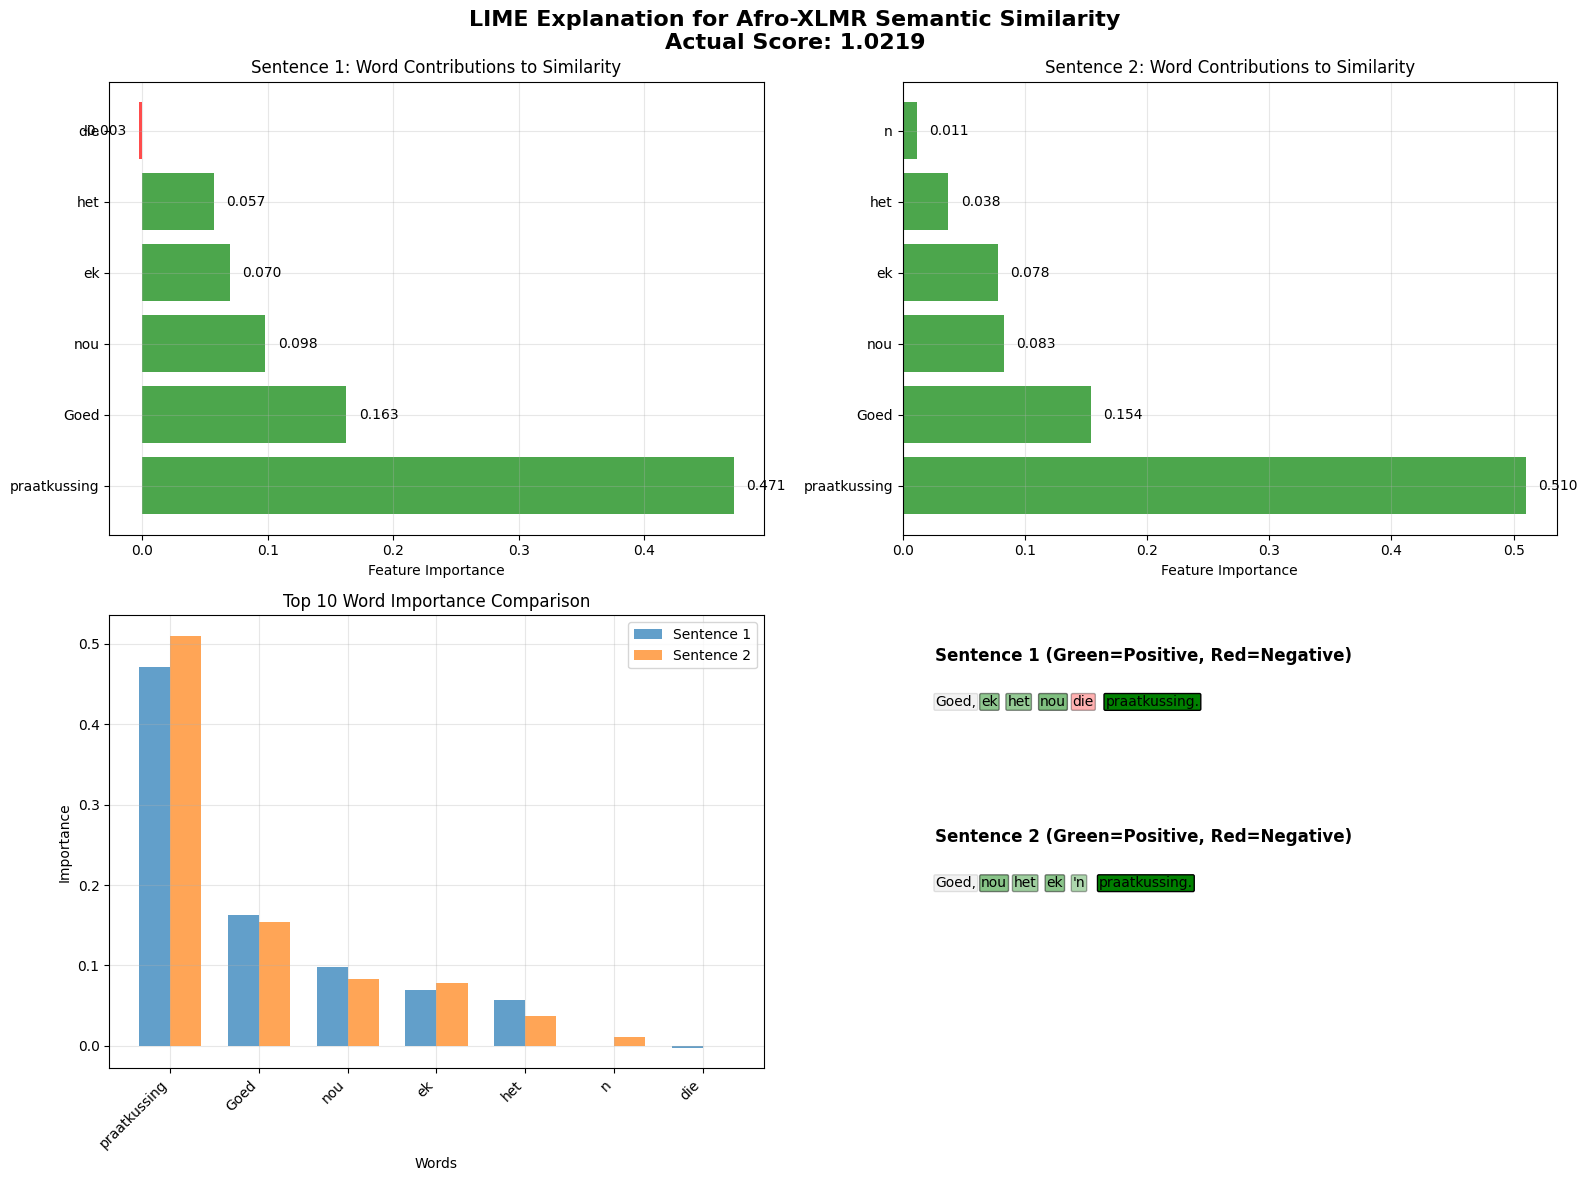

   ✅ LIME visualization saved to /content/drive/MyDrive/COS760/project/lime_explanations_afroxlmr/lime_explanation_afroxlmr_case_1.png
   🔍 Top features for Sentence 1:
      'praatkussing': 0.4715
      'Goed': 0.1625
      'nou': 0.0981
      'ek': 0.0696
      'het': 0.0572
   🔍 Top features for Sentence 2:
      'praatkussing': 0.5099
      'Goed': 0.1539
      'nou': 0.0828
      'ek': 0.0778
      'het': 0.0375

📝 Case 2: Low Similarity Case
   Actual: 0.1250, Predicted: 0.1356
   Error: 0.0106
   Sentence 1: Die wit poedelhond kom uit 'n blou tent.
   Sentence 2: 'N Jong seun val van 'n geskeer skaap af terwyl 'n cowboy jaag om te help.
🔍 Analyzing sentence pair with LIME...
Sentence 1: Die wit poedelhond kom uit 'n blou tent.
Sentence 2: 'N Jong seun val van 'n geskeer skaap af terwyl 'n cowboy jaag om te help.
Actual similarity score: 0.1356
Intercept 0.202688309252331
Prediction_local [0.12721419]
Right: 0.1355670541524887
Intercept 0.13654845639454216
Prediction_local [0.128

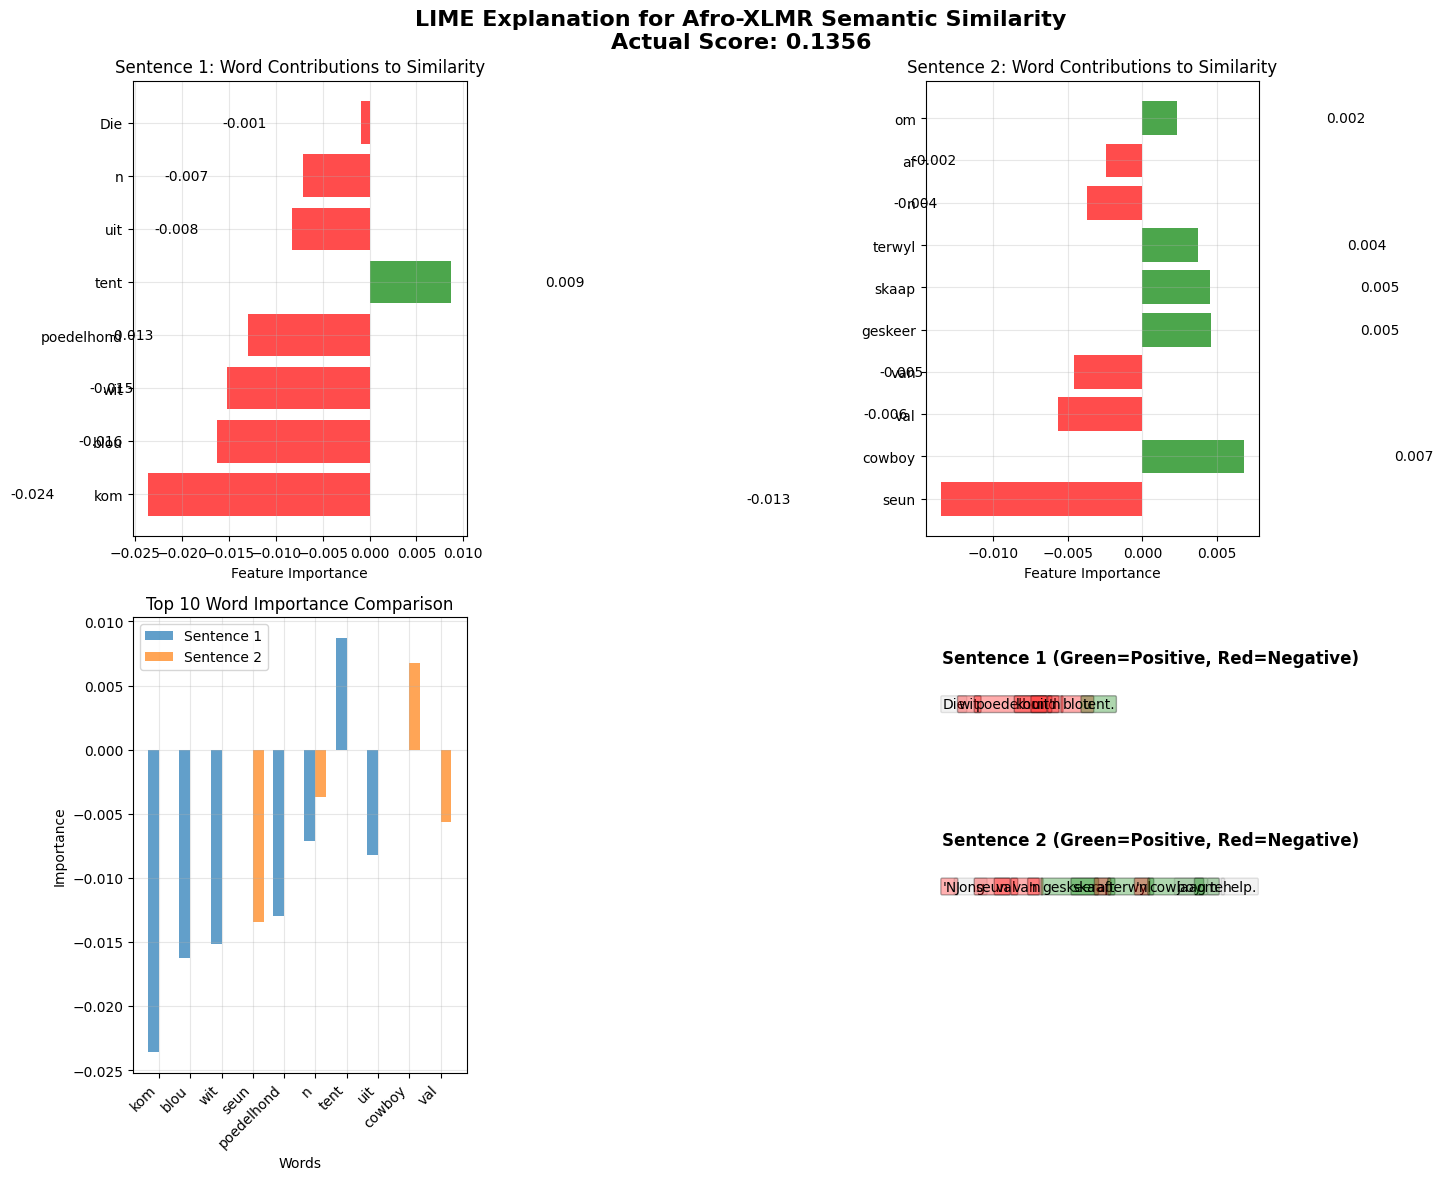

   ✅ LIME visualization saved to /content/drive/MyDrive/COS760/project/lime_explanations_afroxlmr/lime_explanation_afroxlmr_case_2.png
   🔍 Top features for Sentence 1:
      'kom': -0.0236
      'blou': -0.0163
      'wit': -0.0152
      'poedelhond': -0.0130
      'tent': 0.0087
   🔍 Top features for Sentence 2:
      'seun': -0.0135
      'cowboy': 0.0068
      'val': -0.0057
      'van': -0.0046
      'geskeer': 0.0046

📝 Case 3: Largest Prediction Error Case
   Actual: 0.8120, Predicted: 0.3134
   Error: 0.4986
   Sentence 1: Twee jong vroue hardloop snags op die sypaadjie af.
   Sentence 2: Twee vroue wat laat in die straat in die straat dans.
🔍 Analyzing sentence pair with LIME...
Sentence 1: Twee jong vroue hardloop snags op die sypaadjie af.
Sentence 2: Twee vroue wat laat in die straat in die straat dans.
Actual similarity score: 0.3134
Intercept 0.2284795720824424
Prediction_local [0.33482877]
Right: 0.3134302794933319
Intercept 0.20645464655228787
Prediction_local [0.320932

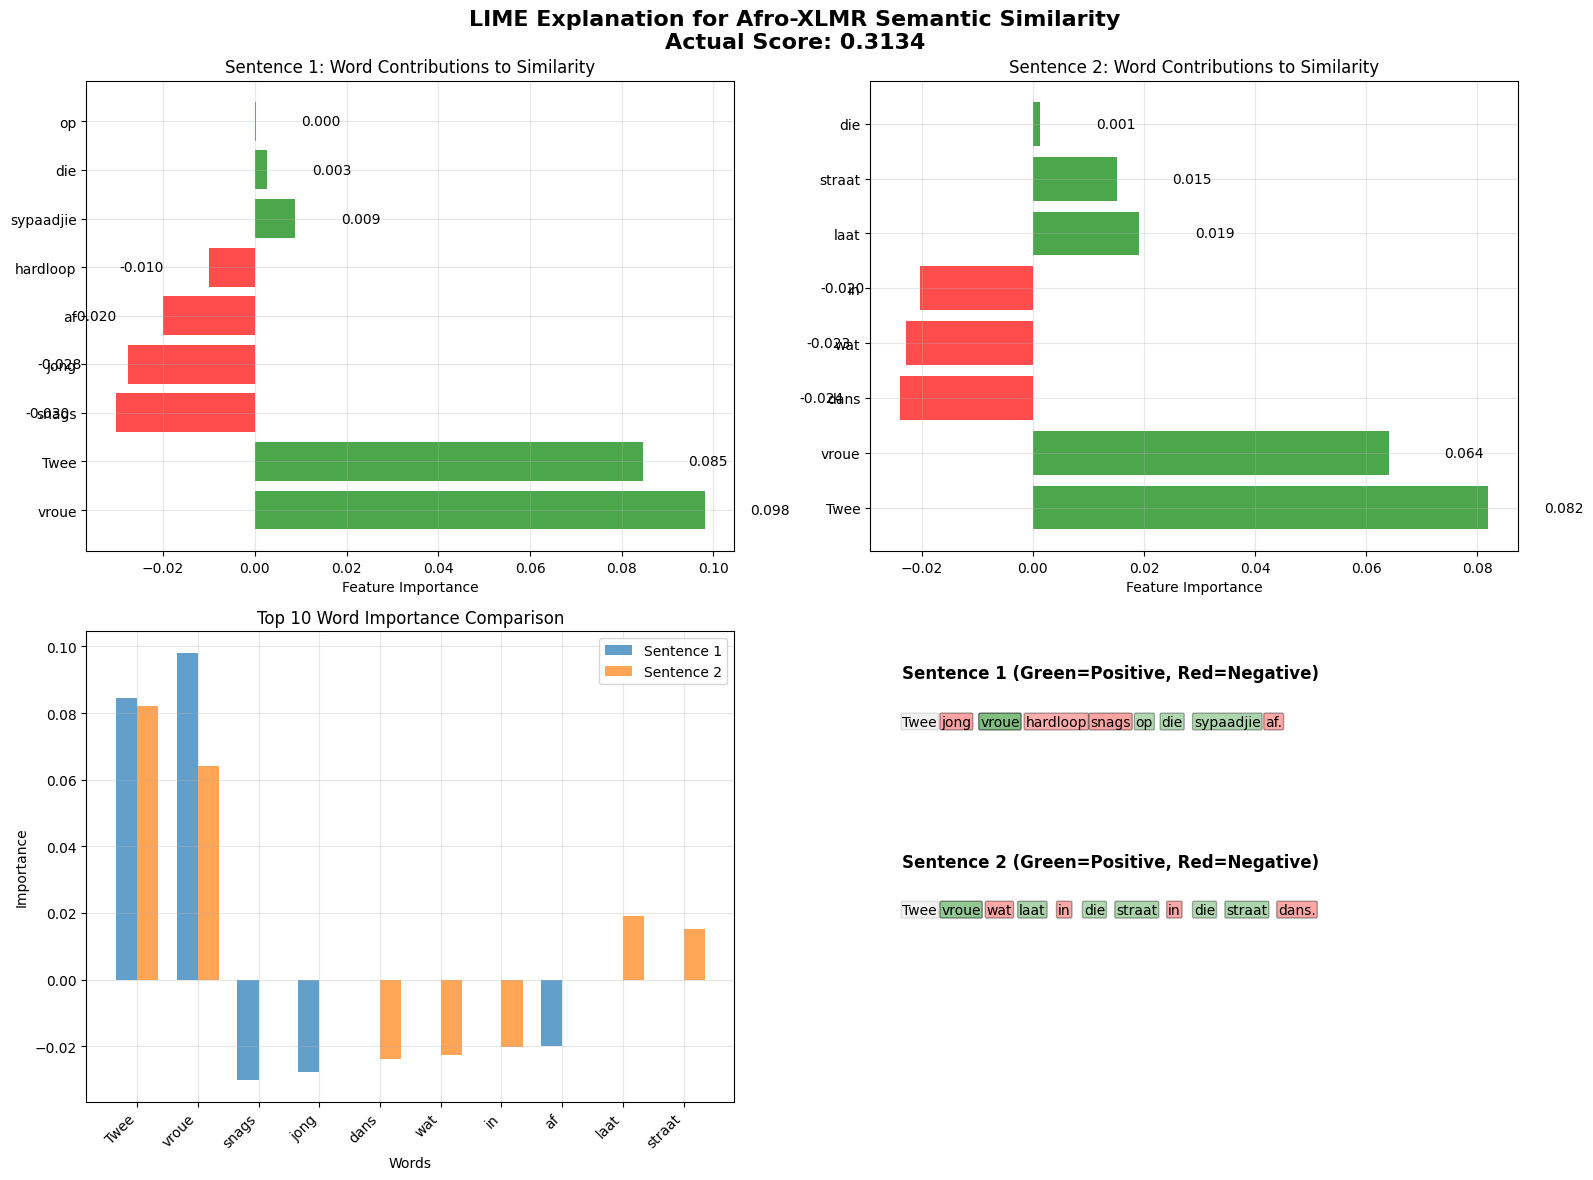

   ✅ LIME visualization saved to /content/drive/MyDrive/COS760/project/lime_explanations_afroxlmr/lime_explanation_afroxlmr_case_3.png
   🔍 Top features for Sentence 1:
      'vroue': 0.0981
      'Twee': 0.0845
      'snags': -0.0303
      'jong': -0.0276
      'af': -0.0201
   🔍 Top features for Sentence 2:
      'Twee': 0.0820
      'vroue': 0.0640
      'dans': -0.0240
      'wat': -0.0228
      'in': -0.0204

✅ LIME analysis completed! Visualizations saved in /content/drive/MyDrive/COS760/project/lime_explanations_afroxlmr


In [ ]:
import lime
import lime.lime_text
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class AfroXLMRLIMEVisualizer:
    """Create LIME explanations for Afro-XLMR semantic similarity predictions"""

    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()  # Set model to evaluation mode

    def create_lime_explainer(self):
        """Create LIME text explainer"""
        return lime.lime_text.LimeTextExplainer(
            class_names=['Dissimilar', 'Similar'],
            feature_selection='forward_selection',
            verbose=True
        )

    def predict_similarity(self, sentence1, sentence2):
        """Get similarity prediction from the model"""
        inputs = self.tokenizer(
            sentence1,
            sentence2,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            output = self.model(**inputs).logits.squeeze().cpu().item()

        return output

    def explain_prediction(self, sentence1, sentence2, num_features=10):
        """
        Explain a single prediction using LIME
        """
        explainer = self.create_lime_explainer()

        # Create a prediction function for this specific pair
        def predict_pair(perturbed_texts):
            """Predict similarity for perturbed versions of the text pair"""
            predictions = []

            for text in perturbed_texts:
                # The perturbed text replaces sentence1, sentence2 stays the same
                similarity = self.predict_similarity(text, sentence2)

                # Convert to probability format (assuming similarity is between -1 and 1 or 0 and 1)
                if similarity < 0:  # If similarity can be negative (like cosine similarity)
                    prob_similar = (similarity + 1) / 2
                else:  # If similarity is already between 0 and 1
                    prob_similar = similarity

                prob_dissimilar = 1 - prob_similar
                predictions.append([prob_dissimilar, prob_similar])

            return np.array(predictions)

        # Get explanation for sentence1 (how it contributes to similarity with sentence2)
        explanation1 = explainer.explain_instance(
            sentence1,
            predict_pair,
            num_features=num_features,
            num_samples=1000
        )

        # Create a prediction function for sentence2
        def predict_pair_reverse(perturbed_texts):
            """Predict similarity for perturbed versions of sentence2"""
            predictions = []

            for text in perturbed_texts:
                similarity = self.predict_similarity(sentence1, text)

                # Convert to probability format
                if similarity < 0:
                    prob_similar = (similarity + 1) / 2
                else:
                    prob_similar = similarity

                prob_dissimilar = 1 - prob_similar
                predictions.append([prob_dissimilar, prob_similar])

            return np.array(predictions)

        # Get explanation for sentence2
        explanation2 = explainer.explain_instance(
            sentence2,
            predict_pair_reverse,
            num_features=num_features,
            num_samples=1000
        )

        return explanation1, explanation2

    def visualize_lime_explanation(self, sentence1, sentence2, save_path=None):
        """Create comprehensive LIME visualization"""
        print(f"🔍 Analyzing sentence pair with LIME...")
        print(f"Sentence 1: {sentence1}")
        print(f"Sentence 2: {sentence2}")

        # Get actual prediction
        actual_similarity = self.predict_similarity(sentence1, sentence2)
        print(f"Actual similarity score: {actual_similarity:.4f}")

        # Get LIME explanations
        explanation1, explanation2 = self.explain_prediction(sentence1, sentence2)

        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'LIME Explanation for Afro-XLMR Semantic Similarity\nActual Score: {actual_similarity:.4f}',
                    fontsize=16, fontweight='bold')

        # Plot 1: Sentence 1 feature importance
        ax1 = axes[0, 0]
        features1 = explanation1.as_list()
        words1 = [f[0] for f in features1]
        importance1 = [f[1] for f in features1]

        colors1 = ['green' if imp > 0 else 'red' for imp in importance1]
        bars1 = ax1.barh(words1, importance1, color=colors1, alpha=0.7)
        ax1.set_xlabel('Feature Importance')
        ax1.set_title('Sentence 1: Word Contributions to Similarity')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, imp in zip(bars1, importance1):
            width = bar.get_width()
            ax1.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                    f'{imp:.3f}', ha='left' if width >= 0 else 'right', va='center')

        # Plot 2: Sentence 2 feature importance
        ax2 = axes[0, 1]
        features2 = explanation2.as_list()
        words2 = [f[0] for f in features2]
        importance2 = [f[1] for f in features2]

        colors2 = ['green' if imp > 0 else 'red' for imp in importance2]
        bars2 = ax2.barh(words2, importance2, color=colors2, alpha=0.7)
        ax2.set_xlabel('Feature Importance')
        ax2.set_title('Sentence 2: Word Contributions to Similarity')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, imp in zip(bars2, importance2):
            width = bar.get_width()
            ax2.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                    f'{imp:.3f}', ha='left' if width >= 0 else 'right', va='center')

        # Plot 3: Combined importance comparison
        ax3 = axes[1, 0]
        all_words = list(set(words1 + words2))

        # Get importance for each word in both sentences
        word_importance1 = {word: imp for word, imp in features1}
        word_importance2 = {word: imp for word, imp in features2}

        combined_importance = []
        for word in all_words:
            imp1 = word_importance1.get(word, 0)
            imp2 = word_importance2.get(word, 0)
            combined_importance.append((word, imp1, imp2))

        # Sort by absolute combined importance
        combined_importance.sort(key=lambda x: abs(x[1]) + abs(x[2]), reverse=True)

        # Take top 10 words
        top_words = combined_importance[:10]
        words = [item[0] for item in top_words]
        imp1_values = [item[1] for item in top_words]
        imp2_values = [item[2] for item in top_words]

        x = np.arange(len(words))
        width = 0.35

        bars1 = ax3.bar(x - width/2, imp1_values, width, label='Sentence 1', alpha=0.7)
        bars2 = ax3.bar(x + width/2, imp2_values, width, label='Sentence 2', alpha=0.7)

        ax3.set_xlabel('Words')
        ax3.set_ylabel('Importance')
        ax3.set_title('Top 10 Word Importance Comparison')
        ax3.set_xticks(x)
        ax3.set_xticklabels(words, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: Highlighted text visualization
        ax4 = axes[1, 1]
        ax4.axis('off')

        # Create highlighted text
        def highlight_text(text, word_importance, ax, y_pos, title):
            words = text.split()
            x_pos = 0.05
            ax.text(x_pos, y_pos + 0.1, title, fontweight='bold', fontsize=12, transform=ax.transAxes)

            for word in words:
                # Clean word for matching
                clean_word = re.sub(r'[^\w]', '', word.lower())
                importance = word_importance.get(clean_word, 0)

                # Color based on importance
                if importance > 0:
                    color = 'green'
                    alpha = min(0.3 + abs(importance) * 2, 1.0)
                elif importance < 0:
                    color = 'red'
                    alpha = min(0.3 + abs(importance) * 2, 1.0)
                else:
                    color = 'gray'
                    alpha = 0.1

                # Add word with background color
                bbox = dict(boxstyle="round,pad=0.1", facecolor=color, alpha=alpha)
                ax.text(x_pos, y_pos, word, bbox=bbox, fontsize=10, transform=ax.transAxes)

                # Update x position (approximate)
                x_pos += len(word) * 0.01 + 0.02
                if x_pos > 0.95:  # Wrap to next line
                    x_pos = 0.05
                    y_pos -= 0.08

        highlight_text(sentence1, word_importance1, ax4, 0.8, "Sentence 1 (Green=Positive, Red=Negative)")
        highlight_text(sentence2, word_importance2, ax4, 0.4, "Sentence 2 (Green=Positive, Red=Negative)")

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return explanation1, explanation2

def create_afroxlmr_lime_visualizations(model, tokenizer, device, results_df, output_dir="../saves/eval_results"):
    """Create LIME visualizations for Afro-XLMR model"""

    print("\n🔍 Creating LIME visualizations for Afro-XLMR model interpretability...")

    # Create LIME visualizer
    lime_viz = AfroXLMRLIMEVisualizer(model, tokenizer, device)

    # Create LIME output directory
    lime_dir = os.path.join(output_dir, "lime_explanations_afroxlmr")
    os.makedirs(lime_dir, exist_ok=True)

    # Find interesting cases for visualization
    high_similarity_idx = results_df['predicted'].idxmax()
    low_similarity_idx = results_df['predicted'].idxmin()
    largest_error_idx = results_df['abs_error'].idxmax()

    cases_to_analyze = [
        (high_similarity_idx, "High Similarity Case"),
        (low_similarity_idx, "Low Similarity Case"),
        (largest_error_idx, "Largest Prediction Error Case")
    ]

    print(f"\n🎯 Analyzing {len(cases_to_analyze)} interesting cases...")

    for idx, (case_idx, case_name) in enumerate(cases_to_analyze):
        row = results_df.iloc[case_idx]
        sentence1 = row['sentence1']
        sentence2 = row['sentence2']
        actual_label = row['true_label']
        predicted_score = row['predicted']
        error = row['abs_error']

        print(f"\n📝 Case {idx + 1}: {case_name}")
        print(f"   Actual: {actual_label:.4f}, Predicted: {predicted_score:.4f}")
        print(f"   Error: {error:.4f}")
        print(f"   Sentence 1: {sentence1}")
        print(f"   Sentence 2: {sentence2}")

        # Create LIME visualization
        save_path = os.path.join(lime_dir, f"lime_explanation_afroxlmr_case_{idx + 1}.png")

        try:
            explanation1, explanation2 = lime_viz.visualize_lime_explanation(
                sentence1, sentence2, save_path=save_path
            )
            print(f"   ✅ LIME visualization saved to {save_path}")

            # Print top features
            print(f"   🔍 Top features for Sentence 1:")
            for word, importance in explanation1.as_list()[:5]:
                print(f"      '{word}': {importance:.4f}")

            print(f"   🔍 Top features for Sentence 2:")
            for word, importance in explanation2.as_list()[:5]:
                print(f"      '{word}': {importance:.4f}")

        except Exception as e:
            print(f"   ❌ Failed to create LIME visualization: {e}")
            continue

    print(f"\n✅ LIME analysis completed! Visualizations saved in {lime_dir}")

# Install LIME if not already installed
!pip install lime

create_afroxlmr_lime_visualizations(model, tokenizer, device, results_df)

# You can also analyze specific examples manually:
def analyze_specific_example(model, tokenizer, device, sentence1, sentence2):
    """Analyze a specific sentence pair with LIME"""
    lime_viz = AfroXLMRLIMEVisualizer(model, tokenizer, device)
    explanation1, explanation2 = lime_viz.visualize_lime_explanation(sentence1, sentence2)
    return explanation1, explanation2


In [ ]:
# List of seeds to run training with
seeds = [42, 77, 123, 2024, 16, 9, 31415, 54, 76, 3]
metrics_log = []

for seed in seeds:
    print(f"\n=== Training with SEED {seed} ===")
    set_all_seeds(seed)

    # Initialize fresh model each time
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=1,
        problem_type="regression"
    ).to(device)

    # Adjust output_dir for each seed to avoid overwriting
    output_dir = os.path.join("../saves/eval_results/", f"checkpoint_seed_{seed}")

    tokenized_train = tokenized_train.shuffle(seed=seed)
    tokenized_eval = tokenized_train.shuffle(seed=seed)

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        num_train_epochs=NUM_EPOCHS,
        save_strategy="no",  # We only care about the final model for seed 42
        report_to="none",
        logging_dir=os.path.join("../saves/", "logs"),
        logging_steps=10,
        logging_strategy="steps",
        seed=seed
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_eval,
        compute_metrics=compute_metrics
    )

    trainer.train()
    print(f"✅ Finished training for seed {seed}")

    eval_results = trainer.evaluate()
    eval_results["seed"] = seed
    metrics_log.append(eval_results)

    # Progressive save of metrics
    print(f"✅ Saving metrics for seed {seed}")
    metrics_df = pd.DataFrame(metrics_log)
    metrics_csv_path = os.path.join("../saves/eval_results/", f"metrics_to_seed{seed}.csv")
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Memory cleanup
    del model
    torch.cuda.empty_cache()

# Save all metrics to CSV
metrics_df = pd.DataFrame(metrics_log)
metrics_csv_path = os.path.join("../saves/eval_results/", "metrics_by_seed.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"✅ Saved all metrics to {metrics_csv_path}")
